In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim

In [14]:
#data
data_dir = "flower_data"
train_dir =  data_dir + "/train"
valid_dir =  data_dir + "/valid"

In [15]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
data_transform = transforms.Compose([    
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)
])

train_dataset = datasets.ImageFolder(train_dir,data_transform)
valid_dataset = datasets.ImageFolder(valid_dir,data_transform)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=64,shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=64,shuffle=True)

In [18]:
#Visualise some of the data
dataiterator = iter(train_loader)
imgs, labels = dataiterator.next()
imgs = imgs.numpy()
labels = labels.numpy()
print(imgs.shape)
print(labels.shape)

(64, 3, 224, 224)
(64,)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


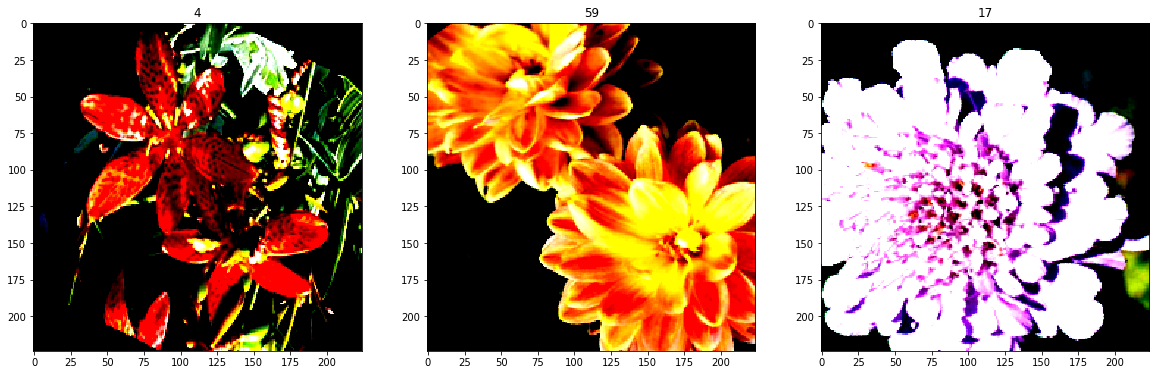

In [35]:
%matplotlib inline
fig = plt.figure(figsize=(20,20))
for indx in range(3):
    ax = fig.add_subplot(1,3,indx+1)
    plt.imshow(np.transpose((imgs[indx])))
    ax.set_title(labels[indx])
